# Machine Learning Clustering with Python

Data yang digunakan adalah informasi kartu kredit customer. Data dapat diakses di [kaggle](https://www.kaggle.com/datasets/aryashah2k/credit-card-customer-data)

Algoritma yang akan digunakan adalah K-Means dan DBSCAN. Performa masing masing algoritma akan diukur di akhir notebook ini.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Data Exploration dan Preprocessing

Setelah data dibaca ke memori, lakukan pembersihan data diantaranya handle missing value, perbaikan tipe data, normalisasi, dan transformasikan variabel kategorik

In [2]:
data_path = os.path.join('data', 'Credit Card Customer Data.csv')
data = pd.read_csv(data_path)
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [4]:
data.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

## Build Model

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = data.iloc[:, 2:]
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print('Variasi yang diwakili principal component:', pca.explained_variance_ratio_)

Variasi yang diwakili principal component: [0.45736578 0.37426483]


In [6]:
X_pca_df = pd.DataFrame(data=X_pca, columns=['pc1', 'pc2'])
X_pca_df.head()

,pc1,pc2
0,0.501291,0.524829
1,-1.459560,3.105588
2,0.525795,0.823979
3,-0.362294,0.128123
4,1.266228,3.668708


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

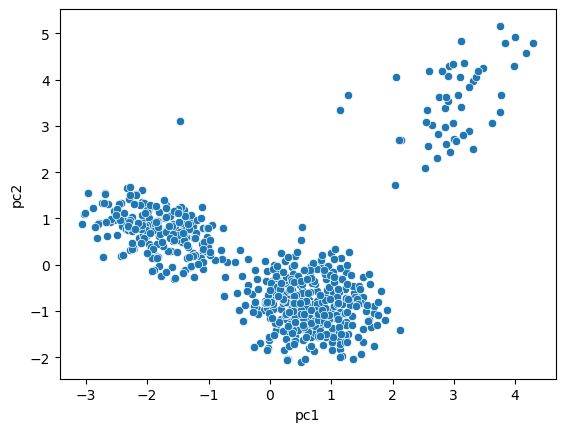

In [7]:
import seaborn as sns

sns.scatterplot(x='pc1', y='pc2', data=X_pca_df)

### K-Means

Dari hasil visualisasi terlihat bahwa data terbagi ke dalam 3 cluster

In [8]:
os.environ['OMP_NUM_THREADS'] = '3'
from sklearn.cluster import KMeans, DBSCAN

K = 3
kmeans = KMeans(K)
kmeans_df = X_pca_df.copy()
kmeans_df['cluster'] = kmeans.fit_predict(X)
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
kmeans_df['cen_x'] = kmeans_df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
kmeans_df['cen_y'] = kmeans_df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
kmeans_df['c'] = kmeans_df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

f:\miniconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


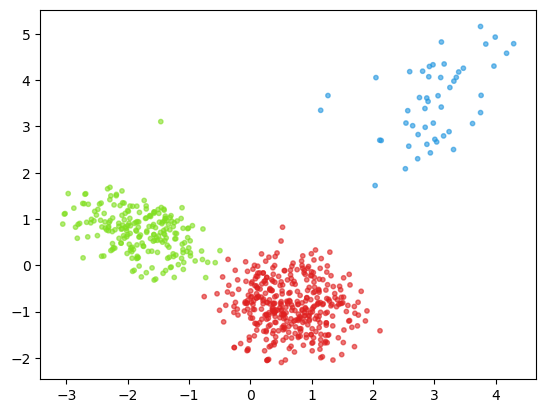

In [9]:
plt.scatter(kmeans_df.pc1, kmeans_df.pc2, c=kmeans_df.c, alpha = 0.6, s=10)

### DBSCAN

DBSCAN memerlukan parameter $\epsilon$ dan `minPts`. `minPts` didapat dari `2 * jumlah fitur`.

Untuk mencari $\epsilon$ yang optimal kita gunakan algoritma KNN. `NearestNeighbors` memerlukan `n_neighbors` yang mana sama dengan `minPts`, tapi ditambah satu karena kolom pertama bernilai 0 semua.

In [10]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=11).fit(X)
neigh_dist , neigh_ind = nbrs.kneighbors(X)
sort_neigh_dist = np.sort(neigh_dist, axis=0)

In [8]:
import plotly.express as px

k_dist = sort_neigh_dist[:, 4]
fig = px.line(k_dist)
fig.show()

Dari plot diatas didapat bahwa nilai $\epsilon$ terbaik adalah 0.8. Nilai diatas 0.8 adalah noise dan outliers

In [37]:
dbscan = DBSCAN(eps=0.8, min_samples=10)

dbscan_df = X_pca_df.copy()
dbscan_df['cluster'] = dbscan.fit_predict(X)
dbscan_df.cluster.value_counts()

 0    606
-1     54
Name: cluster, dtype: int64

Nilai -1 dianggap sebagai outlier

In [34]:

# get centroids
# centroids = dbscan.cluster_centers_
# cen_x = [i[0] for i in centroids] 
# cen_y = [i[1] for i in centroids]
# ## add to df
# kmeans_df['cen_x'] = kmeans_df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
# kmeans_df['cen_y'] = kmeans_df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})
# define and map colors
colors = ['#DF2020', 'grey']
dbscan_df['c'] = dbscan_df.cluster.map({0:colors[0], -1:colors[1]})

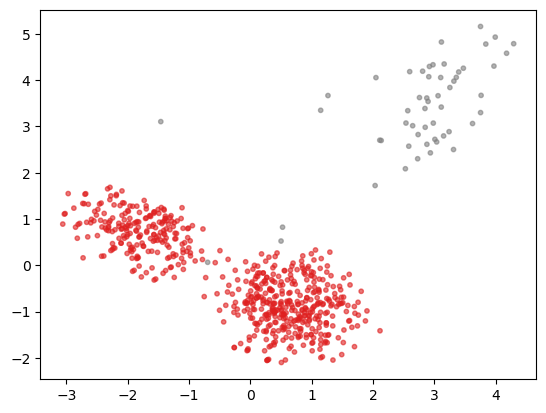

In [35]:
plt.scatter(dbscan_df.pc1, dbscan_df.pc2, c=dbscan_df.c, alpha = 0.6, s=10)

Hasil clustering dengan DBSCAN menghasilkan 1 cluster saja dengan beberapa outlier. Warna abu-abu menunjukkan outliernya.

## Evaluasi Model

In [40]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

sil_sc_kmeans = silhouette_score(X, kmeans_df['cluster'])
sil_sc_dbscan = silhouette_score(X, dbscan_df['cluster'])

pd.Series([sil_sc_kmeans, sil_sc_dbscan], index=['kmeans', 'dbscan'])

In [39]:
cal_har_kmeans = calinski_harabasz_score(X, kmeans_df['cluster'])
cal_har_dbscan = calinski_harabasz_score(X, dbscan_df['cluster'])

pd.Series([cal_har_kmeans, cal_har_dbscan], index=['kmeans', 'dbscan'])

kmeans    833.342627
dbscan    332.423649
dtype: float64

In [41]:
dav_bou_kmeans = davies_bouldin_score(X, kmeans_df['cluster'])
dav_bou_dbscan = davies_bouldin_score(X, dbscan_df['cluster'])

pd.Series([dav_bou_kmeans, dav_bou_dbscan], index=['kmeans', 'dbscan'])

kmeans    0.679699
dbscan    0.725453
dtype: float64

## Kesimpulan

Evaluasi model menggunakan 3 metrik yaitu Silhouette Score, Calinski-Harabasz Score, dan Davies-Bouldin. Pada intinya nilai pada silhouette score dan Calinski-Harabasz Score lebih tinggi lebih baik, namun untuk Davies-Bouldin Score nilai lebih rendah yang lebih baik.

| Model | Silhouette Score | Calinski-Harabasz Score | Davies-Bouldin Score
--- | --- | --- | ---
| K-Means | 0.515718 | 833.342627 | 0.679699
| DBSCAN | 0.551147 | 332.423649 | 0.725453

Dari perbandingan diatas model K-Means dengan 3 cluster lebih cocok untuk data ini.